In [1]:
import pandas as pd

In [2]:
article_info = pd.read_csv('data/article_info.csv')
view_log = pd.read_csv('data/view_log.csv')

In [21]:
article_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   articleID    3008 non-null   object
 1   Title        3008 non-null   object
 2   Content      3008 non-null   object
 3   Format       3008 non-null   object
 4   Language     3008 non-null   object
 5   userID       3008 non-null   object
 6   userCountry  659 non-null    object
 7   userRegion   657 non-null    object
dtypes: object(8)
memory usage: 188.1+ KB


In [13]:
article_info[['Format', 'Language']].nunique()

Format      3
Language    5
dtype: int64

In [10]:
view_log.head()

,userID,articleID,userRegion,userCountry
0,USER_0000,ARTICLE_0661,NY,US
1,USER_0000,ARTICLE_2316,NY,US
2,USER_0000,ARTICLE_1345,NY,US
3,USER_0000,ARTICLE_1089,NY,US
4,USER_0000,ARTICLE_1484,NY,US


In [11]:
view_log[['userCountry', 'userRegion']].nunique()

userCountry    21
userRegion     56
dtype: int64

In [20]:
article_info[~article_info['Language'].isin(['pt','en'])]

,articleID,Title,Content,Format,Language,userID,userCountry,userRegion
524,ARTICLE_0524,Costa Rica presenta su primer edificio constru...,"San José, 22 abr (EFE).- Autoridades de Costa ...",HTML,es,USER_0704,NaN,NaN
756,ARTICLE_0756,Request lesson : How and when to use はず(=hazu)...,= Kotoshi no aki made niwa kare ga dekiru hazu...,HTML,la,USER_0617,NaN,NaN
808,ARTICLE_0808,git flow with support,"Lorem ipsum dolor sit amet, consectetur adipis...",HTML,la,USER_1244,NaN,NaN
955,ARTICLE_0955,"Within a Decade, Retail Banks will be Dead","A соuрlе of weeks ago, I found myself sitting ...",HTML,la,USER_1304,NaN,NaN
988,ARTICLE_0988,La RAE lucha contra los anglicismos con una ca...,La Real Academia Española alerta sobre su abus...,HTML,es,USER_1166,NaN,NaN
1388,ARTICLE_1388,"The Algorithm March, Japan's Strangely Enterta...",Arugorizumu Koushin! アルゴリズムこうしん (Algorithm Mar...,HTML,ja,USER_0368,NaN,NaN
2438,ARTICLE_2438,40 Basic Japanese conversations,Japanese conversation using Ninja LINE sticker...,HTML,ja,USER_0368,NaN,NaN


### 소수 언어로 작성된 aritcles

- lang : es, la, ja

In [28]:
article_info[article_info['Language'] == 'ja']


,articleID,Title,Content,Format,Language,userID,userCountry,userRegion
1388,ARTICLE_1388,"The Algorithm March, Japan's Strangely Enterta...",Arugorizumu Koushin! アルゴリズムこうしん (Algorithm Mar...,HTML,ja,USER_0368,NaN,NaN
2438,ARTICLE_2438,40 Basic Japanese conversations,Japanese conversation using Ninja LINE sticker...,HTML,ja,USER_0368,NaN,NaN


# MERGE LANGUAGE of Articles (view_log)

In [32]:
view_log_concat_lang = pd.merge(
    view_log, article_info[['articleID', 'Language']],
    how = 'left',
    on ='articleID'
)

In [38]:
etc_langs = ['es', 'la', 'ja']

In [39]:
view_log_concat_lang.head()

,userID,articleID,userRegion,userCountry,Language
0,USER_0000,ARTICLE_0661,NY,US,en
1,USER_0000,ARTICLE_2316,NY,US,en
2,USER_0000,ARTICLE_1345,NY,US,en
3,USER_0000,ARTICLE_1089,NY,US,en
4,USER_0000,ARTICLE_1484,NY,US,en


In [46]:
for lang in etc_langs:

    # 해당 언어로된 기사를 본 기록
    filter_df = view_log_concat_lang[view_log_concat_lang['Language'] == lang]

    # 소수 언어 기사를 본 유저들 기록 취합
    concat_lst = []

    for user_id in filter_df['userID'].values:
        read_article = view_log_concat_lang[view_log_concat_lang['userID'] == user_id]
        concat_lst.append(read_article)
        print(f'USER : {user_id}, READ ARTICLES : {len(read_article)}')
    break

USER : USER_0240, READ ARTICLES : 12
USER : USER_0341, READ ARTICLES : 44
USER : USER_0704, READ ARTICLES : 169
USER : USER_0891, READ ARTICLES : 88
USER : USER_1063, READ ARTICLES : 950
USER : USER_1304, READ ARTICLES : 889


In [45]:
pd.concat(concat_lst)

,userID,articleID,userRegion,userCountry,Language
7854,USER_0240,ARTICLE_1725,SP,BR,en
7855,USER_0240,ARTICLE_0524,SP,BR,es
7856,USER_0240,ARTICLE_2774,SP,BR,pt
7857,USER_0240,ARTICLE_1426,SP,BR,pt
7858,USER_0240,ARTICLE_2596,SP,BR,pt
...,...,...,...,...,...
40481,USER_1304,ARTICLE_2179,NY,US,en
40482,USER_1304,ARTICLE_2633,NY,US,en
40483,USER_1304,ARTICLE_1874,NY,US,en
40484,USER_1304,ARTICLE_3004,NY,US,en




추천에 있어서 필요한것은 결국 유저들의 로그 데이터가 맞긴함.

그래야 추천해줄 수 있기 때문에

그런데 위처럼 소수 언어로된 기사들을 방문했던 유저들이 소수에서만 활동한다면 쉽지만 그렇지 않은 경우가 존재함.

그래서 이에 대한 추천 방법은 다음과 같이 진행해야함.


### en, pt 기사만 방문한 유저들간 추천
소수 언어로 작성된 기사를 봤던 유저 데이터는 필터링 하여 일반적인 추천 알고리즘을 적용

### 그외(es, la, ja)기사를 봤던 유저들
해당 유저들에 대한 특성을 분석할 필요성이 있음. 이 그룹의 유저들의 경우 특정 뉴스에 관심이 있을경우 해당 뉴스기사만 추천해주면됨. 그런데 소수 기사 뿐만 아니라 굉장히 많은 기사를 본 유저는 소수 기사에 관심도가 높다고 보기 어려움 따라서 추천할때, 소수그룹에 더 유사한 유저가 있냐, 혹은 일반적인 그룹에서 더 유사한 유저가 있냐를 판단하고 추천해줄 필요가 있음. 그 추천 방법은 2가지가 있음
- 두 그룹중 더 가까운 유저의 기록을 바탕으로 해당 유저 기록에 기반한 추천
- 두 그룹의 유사도 비율에 맞추어 상위 n개씩 추천





# 결과 비교 시각화

In [214]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [265]:
# with open('scores.json', 'r') as f:
#     data = json.load(f)

# 국가 가중치를 빼보면..?
# with open('scores_minus.json', 'r') as f:
#     data = json.load(f)


# 지역 가중치를 추가해보자
with open('scores_add_region.json', 'r') as f:
    data = json.load(f)

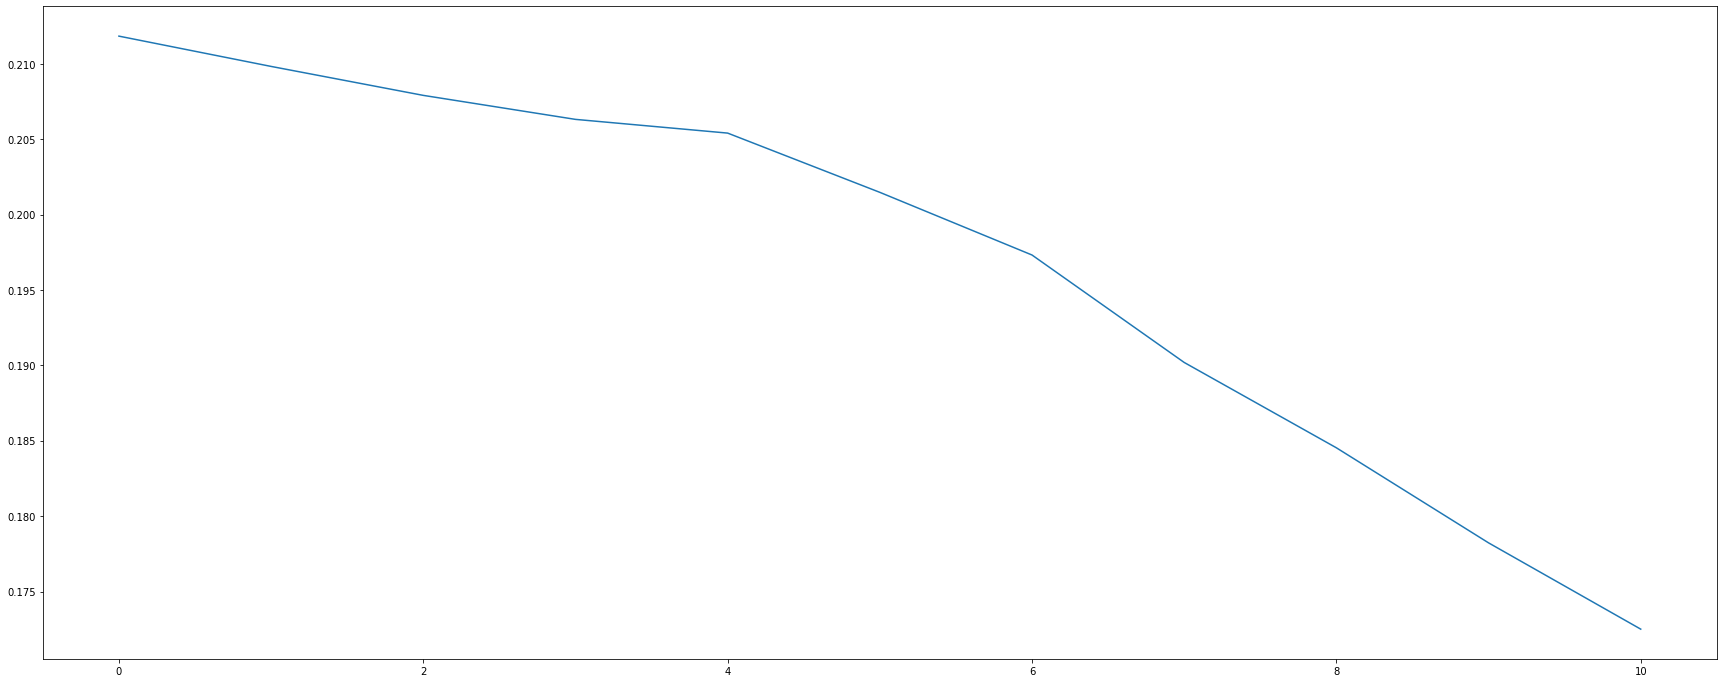

In [266]:
plt.figure(figsize=(30,12))
sns.lineplot(x=np.array(data['weight']), y = data['case1'])
# sns.lineplot(x=np.array(data['weight']) , y = data['case2'])
# sns.lineplot(x=np.array(data['weight']) , y = data['case3'])
plt.show()

In [267]:
data

{'weight': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'case1': [0.21183977760929995,
  0.2098306798079353,
  0.2079100328531716,
  0.2063179176143543,
  0.20540813747788725,
  0.2014783927217589,
  0.19732120293151376,
  0.1901945918625221,
  0.18453373768006068,
  0.17822845590093506,
  0.17250442254233006]}

최종적으로 가장 최적의 값은 0.2이다

### 마이너스 0.1
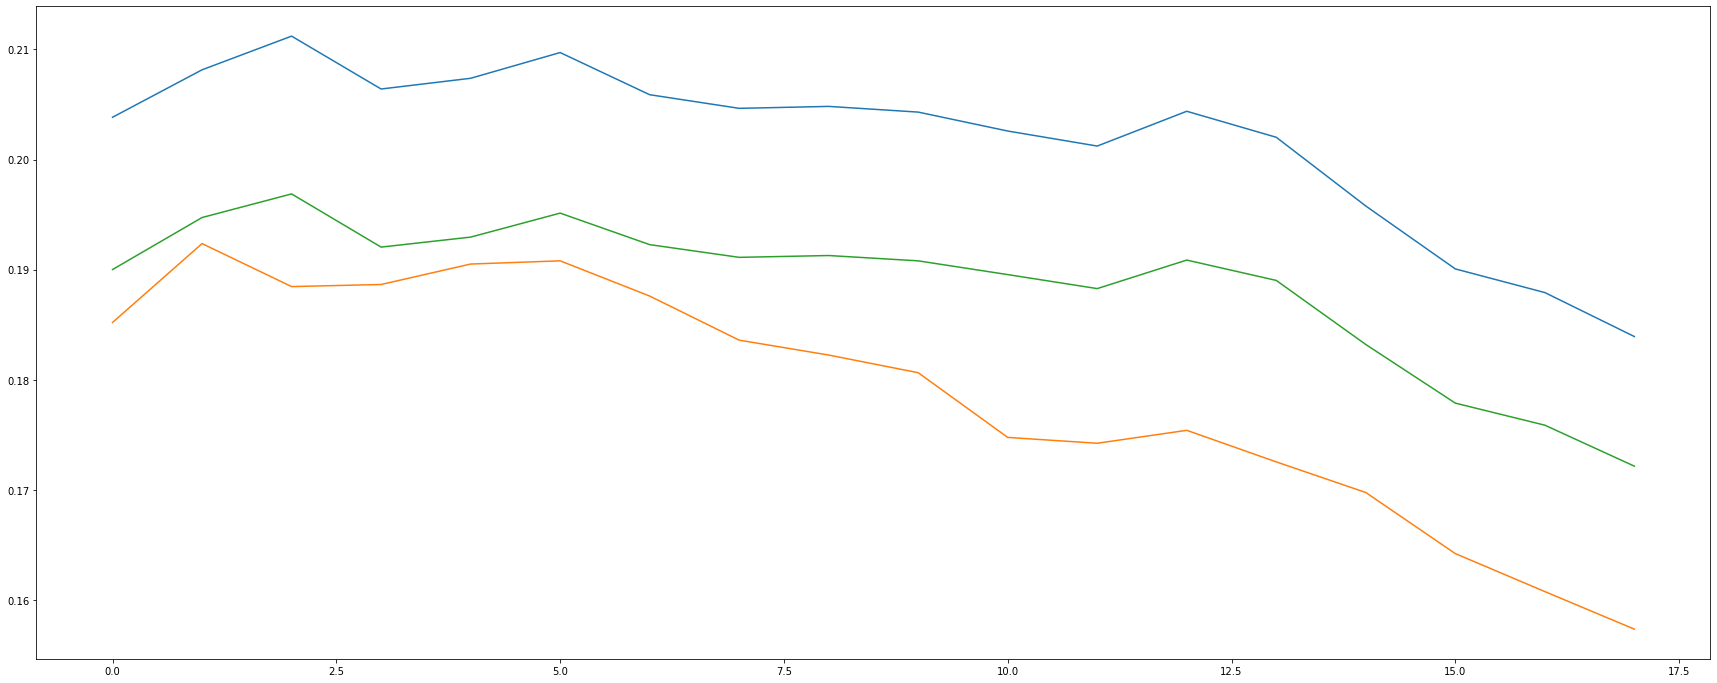

### 마이너스 0.05
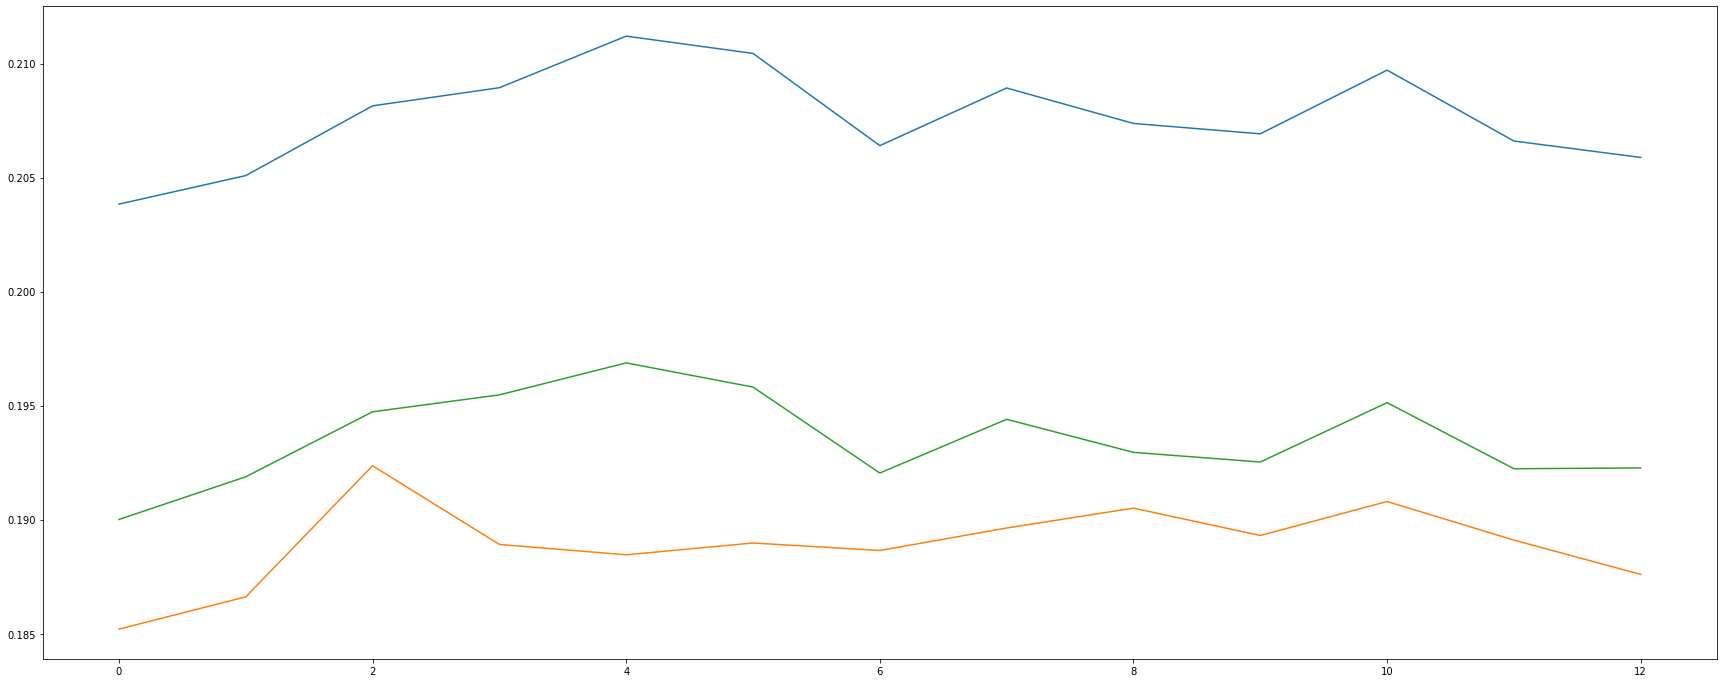

### 마이너스 0.01
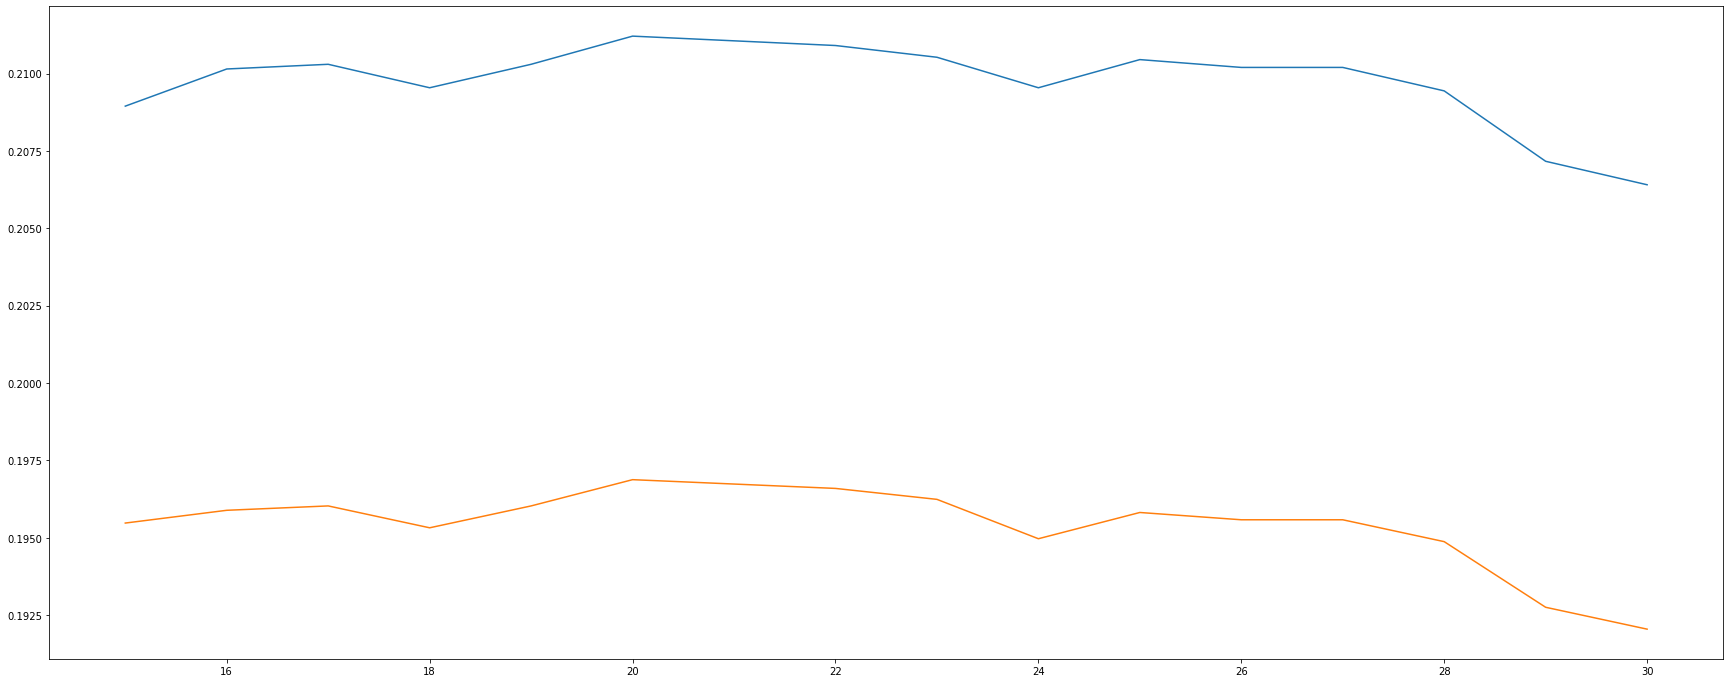

### 지역 가중치 더하기
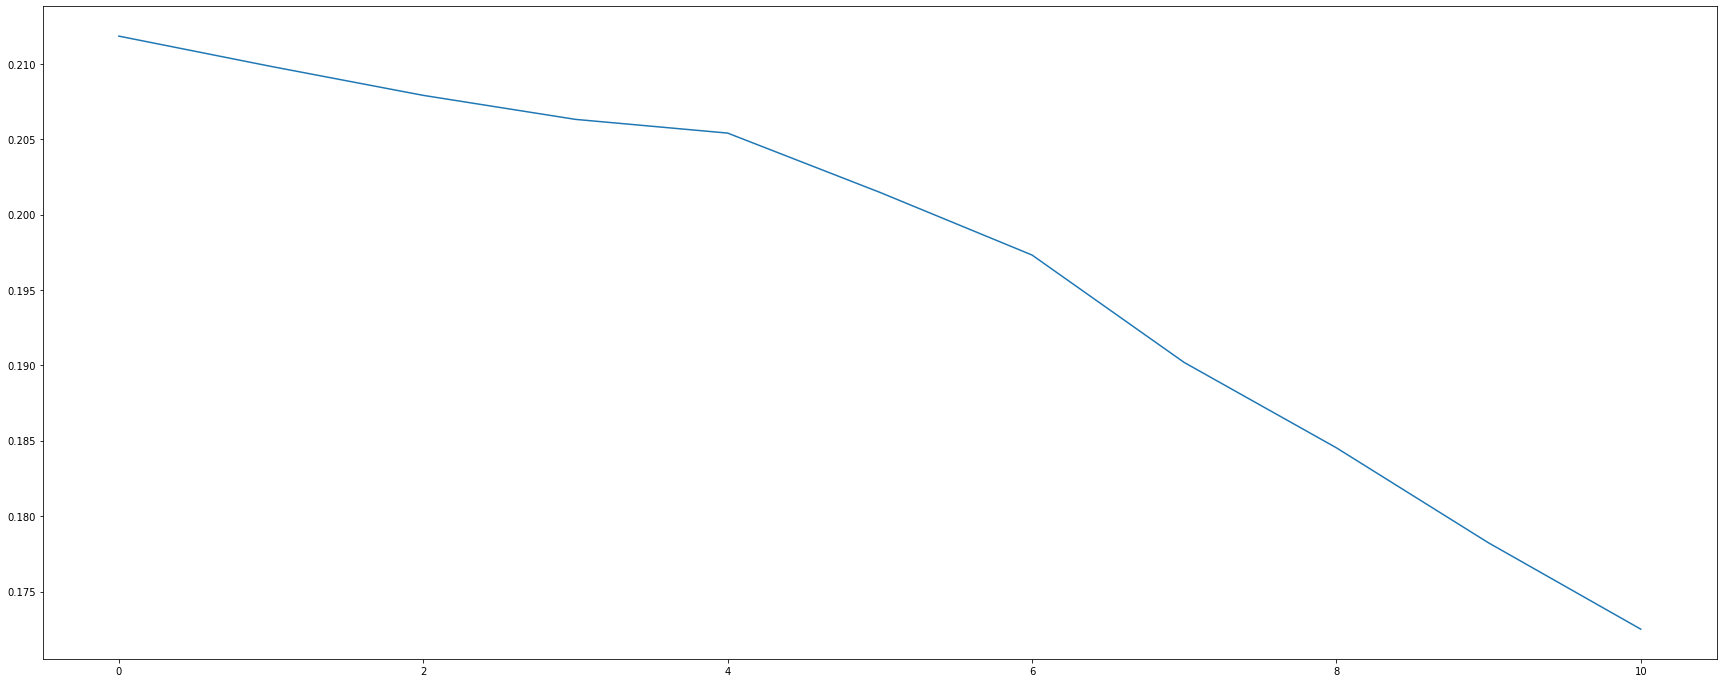

### 지역 가중치 빼기
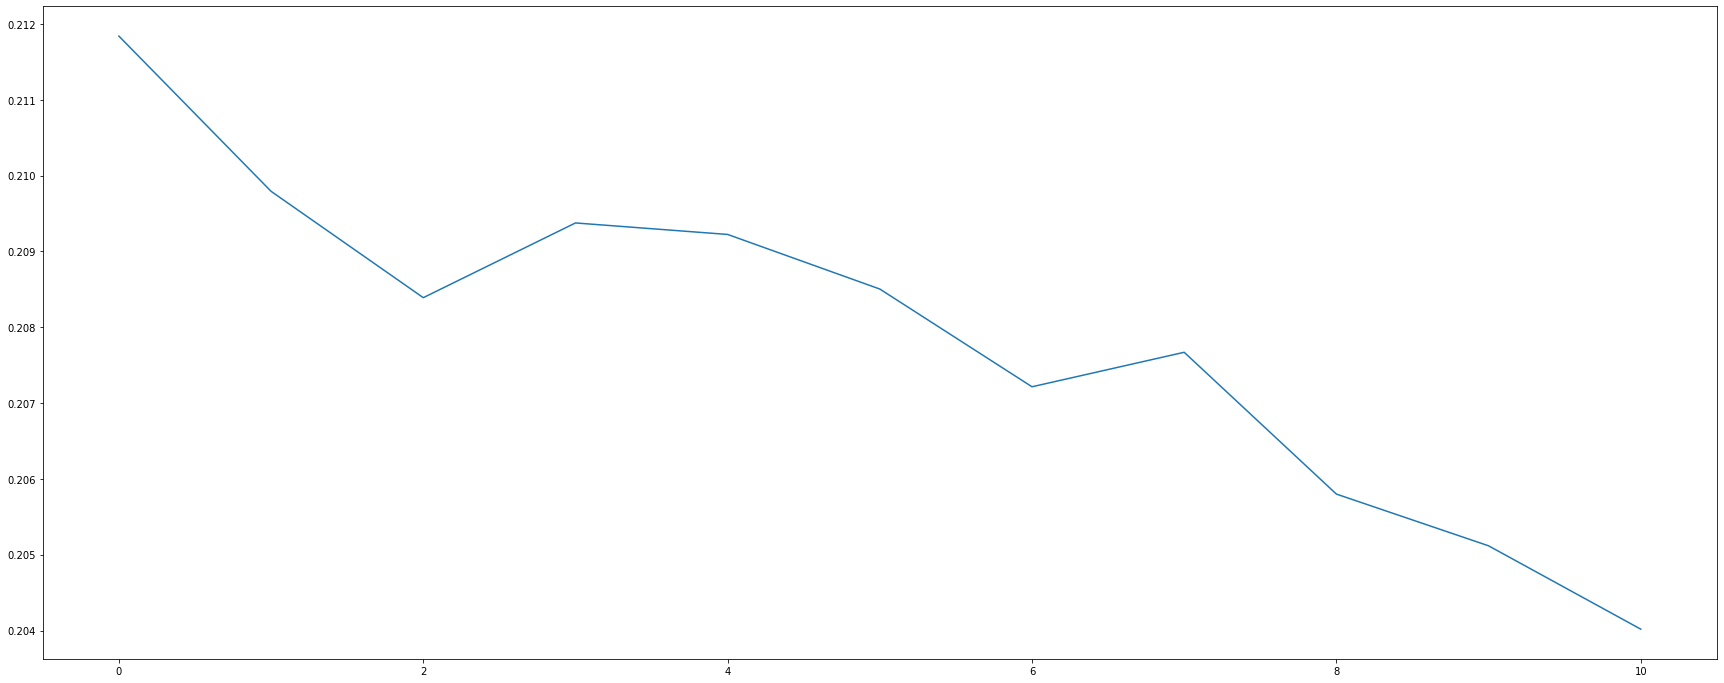